## Import needed libraries
- [numpy](http://cs231n.github.io/python-numpy-tutorial/#numpy-arrays): for multidimensional array computations
- [pandas](http://pandas.pydata.org/): advanced numpy based data structures
- [matplotlib](http://matplotlib.org/): for plots and figures
- [seaborn](http://seaborn.pydata.org/): advanced data visualization library
- [sklearn](http://scikit-learn.org/stable/): machine learning library
- [scipy stats](https://docs.scipy.org/doc/scipy/reference/stats.html): statistical functions

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

### Read the data

In [2]:
train = pd.read_csv('../data/train.csv')
test =  pd.read_csv('../data/test.csv')
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print(all_data.shape)

(2919, 79)


## Preprocessing the data
#### Step 1: Take tranformations of skewed numeric features
#### Step 2: FInding dummy variables for categorical features
#### Step 3: Replacing nan/null values

Before starting the preprocessing, we need to take the log tranformation of the target which Sales Price. This can be done by taking into account non-linearity or errors dues to linear fitting(normalize the errors). For more information about the transformations please check [here](https://people.duke.edu/~rnau/regex3.htm). 

In [3]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#### Let's see the difference 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f725dc2f710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f725b8a1f50>]], dtype=object)

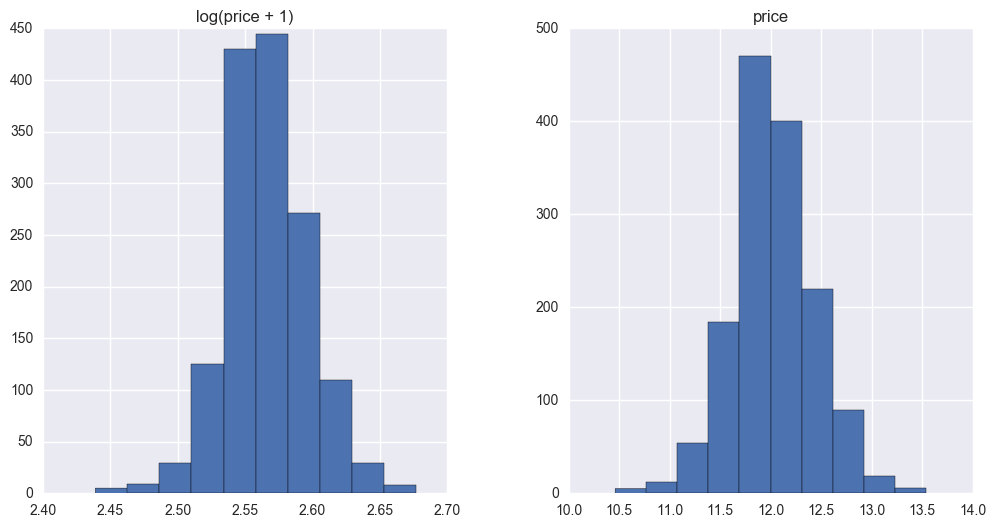

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

### Step 1: Transformations
As explained also above, In this way we will get more normal features 

In [5]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### Step 2: Getting dummy variables
Why to use dummy variables in regression models? please check [here](http://www.psychstat.missouristate.edu/multibook/mlt08m.html)

In [6]:
all_data = pd.get_dummies(all_data)

### Step 3: Imputation of Missing Values
Missing values in each column are filled by the mean of the column.

In [7]:
all_data = all_data.fillna(all_data.mean())


### Optional Steps
#### *Step 4: Removing columns which have moslty zero values (insignificant features can be removed)*
#### *Step 5: Apply outlier analysis for training part*
#### *Step 6: One can also cretae his/her own features to add the data*

### Finalize the data for building the model

In [8]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

#### Optional: to save new data 
Save the currently created matrices for later usage

In [22]:
# new_test = pd.DataFrame(X_test.copy())
# new_test['Id'] = test['Id'].copy()
# new_test.to_csv("../data/new_test.csv", index=False)

# new_train = pd.DataFrame(X_train.copy())
# new_train['SalePrice'] = y.copy()
# new_train.to_csv("../data/new_train.csv", index=False)

## Build Models 
Here we will buil following models by taking advantage of scikit-learn Machine Learning library.
#### * Model 1 : Multiple Regression (Linear Regression)*
#### * Model 2: Bayesian Ridge Regression*
#### *Model 3: Support Vector Regression - non-linear kernels*
#### *Model 4: Random Forest Regression*
#### *Model 5: KNN Regression*
#### *Model 6: Model 6: Multilayer perceptron Regression*

### Model 1 - Multiple Linear Regression
By using all the features in training data, we will fit [Multiple Linear Regression](http://www.stat.yale.edu/Courses/1997-98/101/linmult.htm) to training data.

In [10]:
# Create linear regression object
linear_regr = LinearRegression()
# apply-cross validation
# linear_reg_scores = cross_val_score(linear_regr, X_train, y, cv=5)

# Train the model using the training sets
linear_regr.fit(X_train, y)
# make predictions on the test set
y_linear_regr_pred = linear_regr.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_lr = linear_regr.score(X_train,y)
R2_lr

0.94733494399710361

In [11]:
#save the file
lr_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_linear_regr_pred})
lr_sol.to_csv("../data/linreg_sol.csv", index = False)

### Model 2: Bayesian Ridge Regression
Bayesian Ridge Regression takes advantage of Bayesian statistics and introduces regularization parameters in the estimation procedure of coefficients. More detailed explanation, please check [here]( http://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression).

In [12]:
# Create bayesian regression object
bayes_reg = BayesianRidge(compute_score=True)
# train the model
bayes_reg.fit(X_train, y)
# make predictions on the test set
y_bayes_regr_pred = bayes_reg.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_byr = bayes_reg.score(X_train,y)
R2_byr

0.93412450060140229

In [13]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_bayes_regr_pred})
br_sol.to_csv("../data/bayesreg_sol.csv", index = False)

### Model 3: Support Vector Regression - non-linear kernels
Here we will apply Support Vector Machines for regression and non-linear kernels will be used instead of linear kernels. To get the main intuition behind this technique, please refer to [here](http://kernelsvm.tripod.com/).

In [14]:
# Create SVR object
svr_lin =  SVR(kernel='rbf', C=1e3, gamma=0.1)
# train the model
svr_lin.fit(X_train, y)
# make predictions on the test set
y_svr_regr_pred = svr_lin.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_svr = svr_lin.score(X_train,y)
R2_svr

0.94612459037302221

In [15]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_svr_regr_pred})
br_sol.to_csv("../data/svrreg_sol.csv", index = False)

### Model 4: Random Forest Regression
This method applies Random Forest  as a decision tree classifier and adapts it into regression tasks. For more specific features of this method, please chec [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [15]:
# Create Random Forest regressor object with default settings
rf_regr = RandomForestRegressor()
# train the model
rf_regr.fit(X_train, y)
# make predictions on the test set
y_rf_regr_pred = rf_regr.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_rf = rf_regr.score(X_train,y)
R2_rf

0.97380970282988433

In [16]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_rf_regr_pred})
br_sol.to_csv("../data/rfreg_sol.csv", index = False)

### Model 5: KNN Regression
This method relies on k-nearest neighbor method for regression tasks. Basically, it finds k-nearest neighbor of an observation and averages them to get final value. More info can be seen [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

In [18]:
# Create KNN regression object
knn_regr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
# train the model
knn_regr.fit(X_train, y)
# make predictions on the test set
y_knn_regr_pred = knn_regr.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_knn = knn_regr.score(X_train,y)
R2_knn

0.74316181150475491

In [19]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_knn_regr_pred})
br_sol.to_csv("../data/knnreg_sol.csv", index = False)

### Model 6: Multilayer perceptron Regression

This is an adaptation of neural networks for regression tasks. The main difference is that it doesnot use any activation functions at output layer. For more details, please check [here](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression).

In [21]:
# # Create MLP regression object
mlp_reg = MLPRegressor(hidden_layer_sizes=(20,30,20,20,20), activation='relu', solver='adam',
                        alpha=0.0001, batch_size='auto')
# # train the model
mlp_reg.fit(X_train, y)
# # make predictions on the test set
y_mlp_regr_pred = mlp_reg.predict(X_test)
# calculate R2 value as a measurement of goodness of fit
R2_mlp = mlp_reg.score(X_train,y)
R2_mlp

0.51934369983188033

In [22]:
#save the file
br_sol = pd.DataFrame({"id":test.Id, "SalePrice":y_mlp_regr_pred})
br_sol.to_csv("../data/mlpreg_sol.csv", index = False)

## One-way ANOVA Analysis

Here we are going to implement anova analysis for the obtained results from different classifiers

In [23]:
# to save figures
matplotlib.use('agg')

/home/sinan/anaconda2/envs/gl-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Combine all predictions into single frame
For boxplot analysis, we need to combine all the predictions obtained from every single model on the test data.

In [27]:
## combine these different collections into a list    
data_to_plot = [y_linear_regr_pred, y_bayes_regr_pred,y_knn_regr_pred,
                y_mlp_regr_pred,y_rf_regr_pred,y_svr_regr_pred]


#### Boxplot Analysis
Here we will plot the boxplot to see outliers and any difference among the predictions of each model.

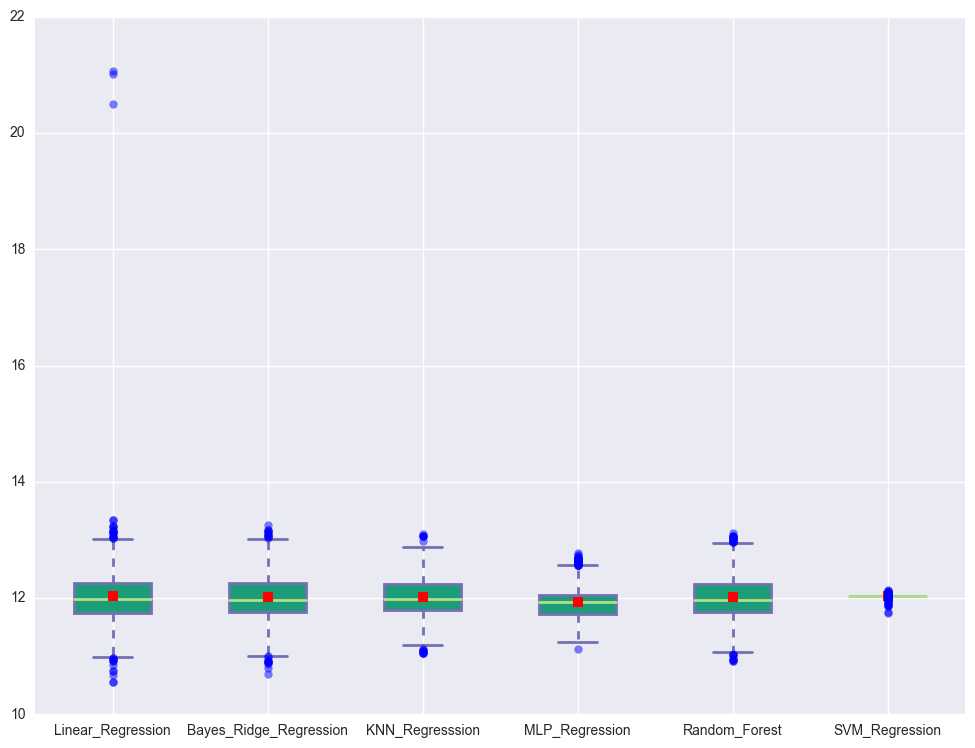

In [25]:
# Create a figure instance
fig = plt.figure(1, figsize=(12, 9))

# Create an axes instance
ax = fig.add_subplot(111)


## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True,showmeans=True)
## Custom x-axis labels
ax.set_xticklabels(['Linear_Regression', 'Bayes_Ridge_Regression', 'KNN_Regresssion', 
                    'MLP_Regression','Random_Forest','SVM_Regression'])
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [28]:
# Save the figure
fig.savefig('../data/fig1.png', bbox_inches='tight')

### Start Anova Analysis
We will first calculate mean and std of each model's predictions and then we will conduct our anova analysis.

#### import related library for anova analysis

In [29]:
from pyvttbl import DataFrame

### Compute mean and std of each prediction set

In [34]:
# compute mean
mean_all = np.mean([y_linear_regr_pred,y_bayes_regr_pred,y_knn_regr_pred,y_mlp_regr_pred,
                            y_rf_regr_pred,y_svr_regr_pred], axis = 0)
mean_all

array([ 11.90210534,  11.94151317,  12.07982438, ...,  12.04482369,
        11.69330536,  12.25373752])

In [35]:
# compute mean
std_all = np.std([y_linear_regr_pred,y_bayes_regr_pred,y_knn_regr_pred,y_mlp_regr_pred,
                            y_rf_regr_pred,y_svr_regr_pred], axis = 0)
std_all

array([ 0.19961446,  0.08577041,  0.0471596 , ...,  0.09256046,
        0.18175635,  0.11246868])

### Run Anova analysis

In [47]:
data1 = pd.DataFrame({"Regression":y_linear_regr_pred,"Group":"Linear"})
data2 = pd.DataFrame({"Regression":y_bayes_regr_pred,"Group":"Bayes"})
data3 = pd.DataFrame({"Regression":y_knn_regr_pred,"Group":"KNN"})
data4 = pd.DataFrame({"Regression":y_mlp_regr_pred,"Group":"MLP"})
data5 = pd.DataFrame({"Regression":y_rf_regr_pred,"Group":"RF"})
data6 = pd.DataFrame({"Regression":y_svr_regr_pred,"Group":"SVR"})
frames = [data1,data2,data3,data4,data5,data6]
result = pd.concat(frames)
pf = DataFrame(result)
# pf.insert(knn_regr)
aov_pyvttbl = pf.anova1way("Regression", "Group")
# # print aov_pyvttbl
# help(pf.anova)
print(aov_pyvttbl)


Anova: Single Factor on Regression

SUMMARY
Groups   Count      Sum      Average   Variance  
Bayes     1459   17522.854    12.010       0.157 
KNN       1459   17538.063    12.021       0.114 
Linear    1459   17547.902    12.027       0.326 
MLP       1459   17408.225    11.932       0.082 
RF        1459   17527.635    12.013       0.141 
SVR       1459   17551.242    12.030   2.798e-04 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation      SS        df      MS       F      P-value    eta^2   Obs. power 
Treatments               84.939      5   16.988   8.016   1.497e-07   0.005        1.000 
Error                 18539.681   8748    2.119                                          
Total                 18624.620   8753                                                   

ANOVA
Source of Variation      SS       df     MS       F       P-value    eta^2   Obs. power 
Treatments               9.969      5   1.994   14.583   2.912e-14   0.008        1.000 
Error              

### save the figure

In [46]:
# from pandas.tools.plotting import table

# ax2 = plt.subplot(111, frame_on=False) # no visible frame
# ax2.xaxis.set_visible(False)  # hide the x axis
# ax2.yaxis.set_visible(False)  # hide the y axis

# table(ax2, pd.DataFrame(aov_pyvttbl))  # where df is your data frame

# plt.savefig('mytable.png')